# Visualize Attention for VisionTransformers
In this notebook we take a look at what Vision Transformers focus on when they do predictions.

In [1]:
#----------------Imports----------------#
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

In [2]:
#------------------------Image Url-----------------------------#
image_url = 'https://images.saymedia-content.com/.image/t_share/MTc0OTcwMzc3MDEyMDYxNjM2/is-playing-fetch-bad-for-my-dog.jpg'

In [3]:
#------------------------To Tensor-----------------------------#
def to_tensor(img):
    """
    Convert an image to a tensor. 
    Args:
        img: Image to be converted. 
    Outputs:
        The converted image tensor.
    Note:
        This function applies a series of transformations to the image, including resizing, center cropping, and converting the image to a tensor.
    """
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor()])
    return transform_fn(img)

#------------------------Original Image-----------------------------#
def show_img(img):
    """
    Display an image.
    Args:
        img: Image to be displayed.
    Note:
        This function converts the image to a numpy array and uses matplotlib to display the image.
    """
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#------------------------Overlay Image-----------------------------#
def show_img2(img1, img2, alpha=0.8):
    """
    Display two images side by side.
    Args:
        img1: First image to be displayed.
        img2: Second image to be displayed.
        alpha: Transparency level of the second image (default: 0.8).
    
    Note:
        This function converts both images to numpy arrays and uses matplotlib to display the images side by side.
    """
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

#------------------------Forward-----------------------------#
def my_forward_wrapper(attn_obj):
    """
    Create a forward pass function with attention map tracking.
    Args:
        attn_obj: The attention object to be used in the forward pass.
    Returns:
        The forward pass function.
    Note:
        This function defines a new forward pass function that tracks the attention map and the class-specific attention map.
    """
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

In [4]:
import requests
from PIL import Image
from torchvision.transforms import ToTensor
from io import BytesIO


# Download the image using requests
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Resize the image to match the expected input size of the model (224x224 in this case)
img = img.resize((224, 224))

# Convert the image to RGB
img = img.convert('RGB')

# Convert the image to a PyTorch tensor
to_tensor = ToTensor()
x = to_tensor(img)

model = create_model('deit_base_distilled_patch16_224', pretrained=True)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)

# Assuming my_forward_wrapper is a custom function to handle forward pass, replace it with your own logic

y = model(x.unsqueeze(0))
attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 1
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

In [5]:
# As we have 12 heads in this model the loop is for 12
image_pairs_list = []
for i in range(0,12):
    model.blocks[-i].attn.forward = my_forward_wrapper(model.blocks[-i].attn)
    y = model(x.unsqueeze(0))
    attn_map = model.blocks[-i].attn.attn_map.mean(dim=1).squeeze(0).detach()
    cls_weight = model.blocks[-i].attn.cls_attn_map.mean(dim=1).view(14, 14).detach()
    img_resized = x.permute(1, 2, 0) * 1
    cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)
    image_pairs_list.append((img_resized, cls_resized))

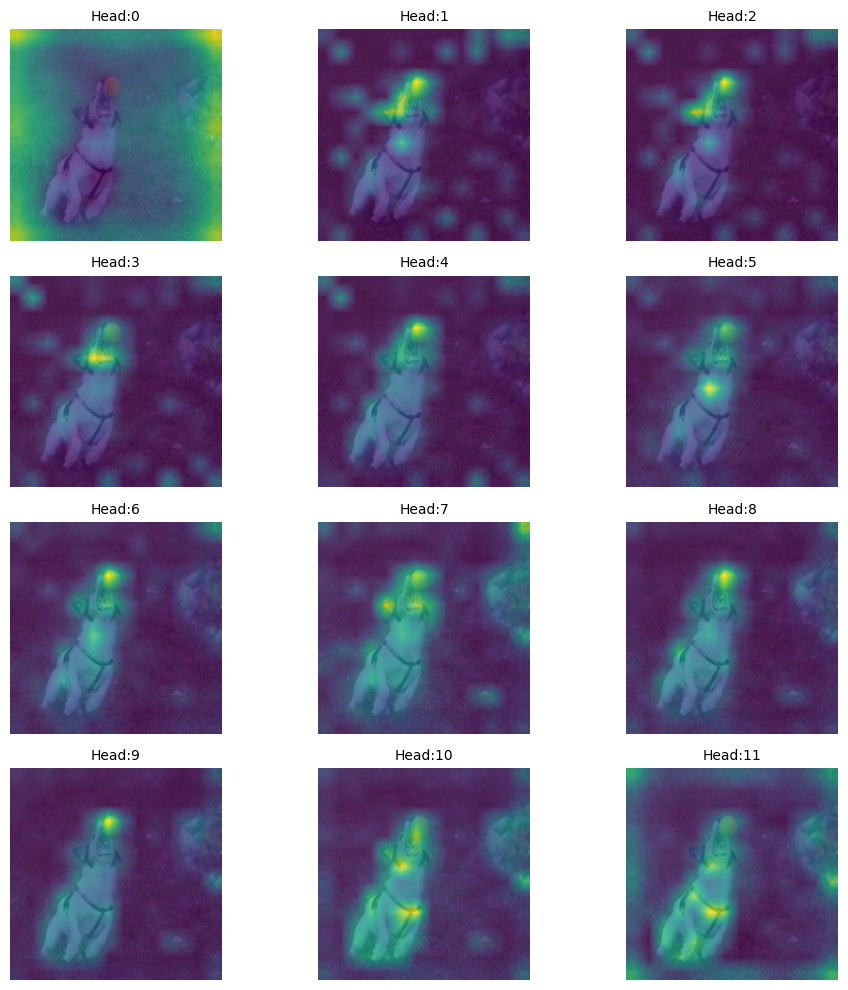

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')


# Create a 4x3 subplot grid
num_rows = 4
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate through the image pairs and plot the overlayed images in the grid
for i in range(num_rows):
    for j in range(num_cols):
        image_pair_index = i * num_cols + j
        if image_pair_index < len(image_pairs_list):
            img1, img2 = image_pairs_list[image_pair_index]
            axes[i, j].imshow(img1)
            axes[i, j].imshow(img2, alpha=0.8)
            axes[i, j].axis('off') 
            axes[i, j].set_title(f'Head:{image_pair_index}', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()